In [ ]:
!pip install jcopml

     |████████████████████████████████| 100 kB 4.9 MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.14-py2.py3-none-any.whl size=33654 sha256=d4c4fd166c85f08ff5d725a12d6c75557487a643f180297f2dbe8750328624d0
  Stored in directory: /root/.cache/pip/wheels/d9/6a/86/9a622c06f65732afe0e31c02a92fae6ab663ffd7162bcf5125
Successfully built jcopml


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [ ]:
df = pd.read_csv('/content/diabetes Mellitus.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Mini EDA

,missing_value,%
Pregnancies,0,0.0
Glucose,0,0.0
BloodPressure,0,0.0
SkinThickness,0,0.0
Insulin,0,0.0
BMI,0,0.0
DiabetesPedigreeFunction,0,0.0
Age,0,0.0
Outcome,0,0.0


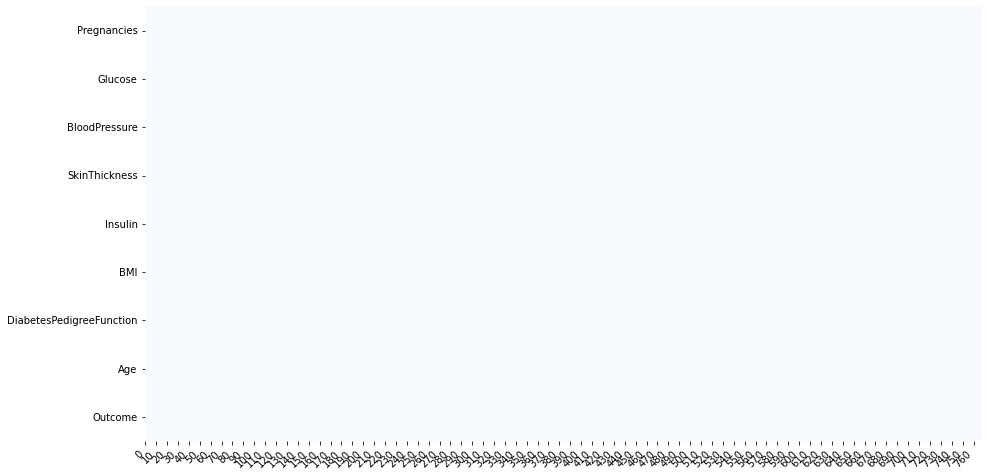

In [ ]:
# Check Missing Value
plot_missing_value(df, return_df=True)

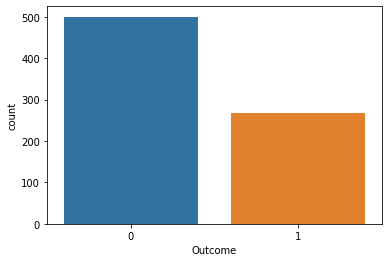

In [ ]:
# Check Imbalanced Data
import seaborn as sns
sns.countplot(data=df, x='Outcome');

In [ ]:
# Check Imbalanced Data
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

# Dataset Splitting

In [ ]:
X = df.drop(columns=['Outcome'])
y = df.Outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

# Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline
from jcopml.tuning import random_search_params as rsp, grid_search_params as gsp, bayes_search_params as bsp # Berisi parameter untuk Tuning model

## Random Forest

In [ ]:
# Pipeline
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X.columns.values)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('sampling', SMOTE()),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# Training
model_rf = GridSearchCV(pipeline, gsp.rf_params, cv=7, n_jobs=-1, verbose=1, scoring='f1')
model_rf.fit(X_train, y_train)

# Evaluation
print(model_rf.best_params_)
print(model_rf.score(X_train, y_train), model_rf.best_score_, model_rf.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.3, 'algo__min_samples_leaf': 10, 'algo__n_estimators': 150}
0.7882882882882883 0.692935705873301 0.6724137931034483


## XGBoost

In [ ]:
# Pipeline
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X.columns.values)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('sampling', SMOTE()),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

# Training
model_xgb = GridSearchCV(pipeline, gsp.xgb_params, cv=7, n_jobs=-1, verbose=1, scoring='f1')
model_xgb.fit(X_train, y_train)

# Evaluation
print(model_xgb.best_params_)
print(model_xgb.score(X_train, y_train), model_xgb.best_score_, model_xgb.score(X_test, y_test))

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits
{'algo__colsample_bytree': 0.4, 'algo__gamma': 5, 'algo__learning_rate': 1, 'algo__max_depth': 3, 'algo__n_estimators': 100, 'algo__reg_alpha': 0.1, 'algo__reg_lambda': 10, 'algo__subsample': 0.6}
0.6917293233082706 0.6821513821513823 0.5576923076923077


# SVM

In [ ]:
# Pipeline
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), X.columns.values)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('sampling', SMOTE()),
    ('algo', SVC(random_state=42))
])

# Training
model_svm = GridSearchCV(pipeline, gsp.svm_params, cv=7, n_jobs=-1, verbose=1, scoring='f1')
model_svm.fit(X_train, y_train)

# Evaluation
print(model_svm.best_params_)
print(model_svm.score(X_train, y_train), model_svm.best_score_, model_svm.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'algo__C': 0.001, 'algo__gamma': 0.1}
0.6719056974459725 0.6706539074960127 0.6165413533834587


# Training with Feature Importance

array(['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction'], dtype=object)

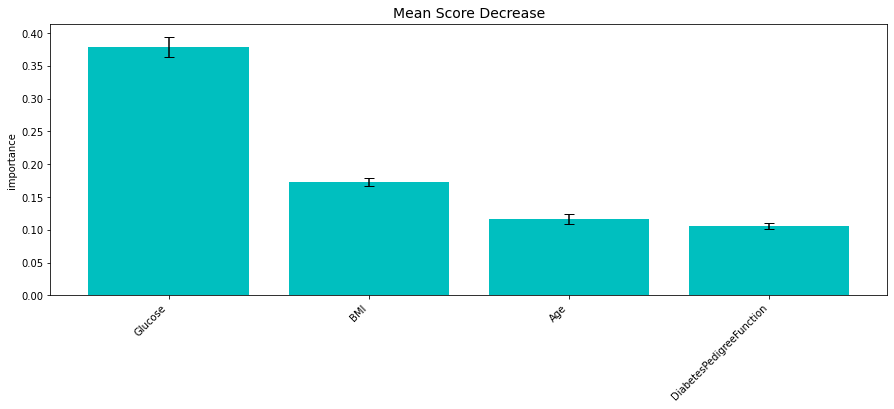

In [ ]:
# Model Random Forest
important_rf = mean_score_decrease(X_train, y_train, model_rf, plot=True, topk=4)
important_rf.feature.values

array(['Glucose', 'Age', 'BMI', 'Insulin'], dtype=object)

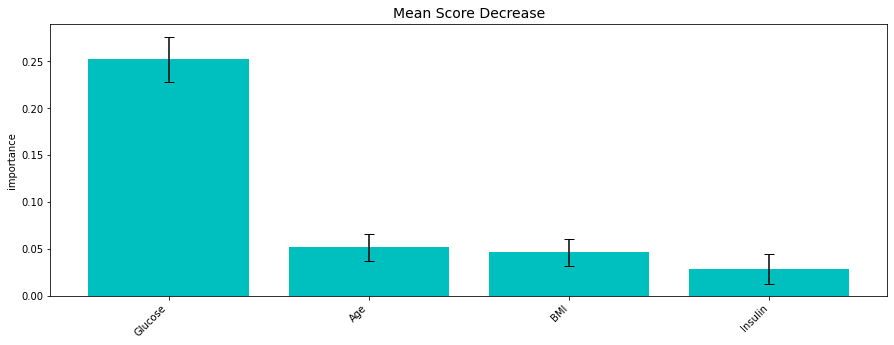

In [ ]:
# Model XGBoost
important_xgb = mean_score_decrease(X_train, y_train, model_xgb, plot=True, topk=4)
important_xgb.feature.values

array(['Glucose', 'BMI', 'Pregnancies', 'DiabetesPedigreeFunction'],
      dtype=object)

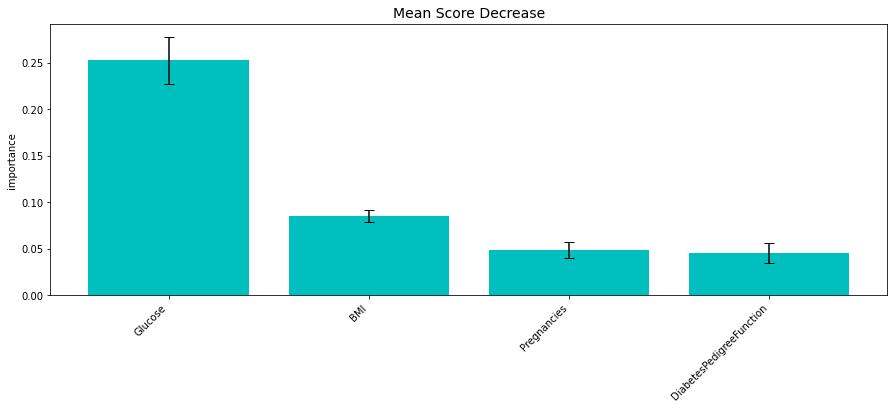

In [ ]:
# Model SVM
important_svm = mean_score_decrease(X_train, y_train, model_svm, plot=True, topk=4)
important_svm.feature.values

## Random Forest

In [ ]:
# Pipeline
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), important_rf.feature.values)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('sampling', SMOTE()),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# Training
model_rf_imp = GridSearchCV(pipeline, gsp.rf_params, cv=7, n_jobs=-1, verbose=1, scoring='f1')
model_rf_imp.fit(X_train, y_train)

# Evaluation
print(model_rf_imp.best_params_)
print(model_rf_imp.score(X_train, y_train), model_rf_imp.best_score_, model_rf_imp.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 150}
1.0 0.6468208938671398 0.5800000000000001


## XGBoost

In [ ]:
# Pipeline
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), important_xgb.feature.values)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('sampling', SMOTE()),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

# Training
model_xgb_imp = GridSearchCV(pipeline, gsp.xgb_params, cv=7, n_jobs=-1, verbose=1, scoring='f1')
model_xgb_imp.fit(X_train, y_train)

# Evaluation
print(model_xgb_imp.best_params_)
print(model_xgb_imp.score(X_train, y_train), model_xgb_imp.best_score_, model_xgb_imp.score(X_test, y_test))

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits
{'algo__colsample_bytree': 0.8, 'algo__gamma': 1, 'algo__learning_rate': 1, 'algo__max_depth': 3, 'algo__n_estimators': 150, 'algo__reg_alpha': 10, 'algo__reg_lambda': 0.01, 'algo__subsample': 0.4}
0.6818181818181819 0.6579877968377267 0.5794392523364486


## SVM

In [ ]:
# Pipeline
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), important_svm.feature.values)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('sampling', SMOTE()),
    ('algo', SVC(random_state=42))
])

# Training
model_svm_imp = GridSearchCV(pipeline, gsp.svm_params, cv=7, n_jobs=-1, verbose=1, scoring='f1')
model_svm_imp.fit(X_train, y_train)

# Evaluation
print(model_svm_imp.best_params_)
print(model_svm_imp.score(X_train, y_train), model_svm_imp.best_score_, model_svm_imp.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'algo__C': 1000.0, 'algo__gamma': 0.01}
0.6933333333333334 0.640888888888889 0.5161290322580646
